In [1]:
import tensorflow as tf
print(f"Tensorflow version : {tf.__version__}")

Tensorflow version : 2.2.0-rc1


In [2]:
from tensorflow.python.ops import sparse_ops
import tensorflow.keras.backend as K
import pandas as pd
# import matplotlib.pyplot as plt
import os
assert tf.__version__=='2.2.0-rc1'
# assert tf.test.is_gpu_available()
K.clear_session()
%load_ext tensorboard
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from ipynb.fs.full.clustering import cluster_maker, cluster_splitter, scalar_features, tf_serialize_example

Tensorflow version : 2.2.0-rc1


## Parser

In [8]:
feature_description = {
    'eventId': tf.io.FixedLenFeature([1], tf.int64, default_value=0),
    'image': tf.io.FixedLenFeature([3], tf.string, default_value=["",]*3)
}

feature_shape = {
    'eventId': tf.TensorShape([1,]),
    'image': tf.TensorShape([568, 568, 2])
}

def parser_fn(proto):
    serialized = tf.io.parse_single_example(proto, feature_description)
    deserialized = {k: (tf.sparse.to_dense(sparse_ops.deserialize_sparse(v, K.floatx()))
                        if k != 'eventId' else v) for k,v in serialized.items()}
    [deserialized[k].set_shape(feature_shape[k]) for k in deserialized.keys()]
    x = deserialized['image']
    x = tf.expand_dims(x, axis=0)
    x = K.pool2d(x, pool_size=(2, 2), strides=(2, 2), pool_mode='avg')
    # sum instead of avg
    x = 2.*x
    deserialized['image'] = tf.squeeze(x)
    deserialized['S_image'] = deserialized['image'][:,:,:1]
    deserialized['C_image'] = deserialized['image'][:,:,-1:]
    
    # set EM633
    deserialized['tseed'] = tf.constant(6., tf.float32)
    deserialized['tneighbour'] = tf.constant(3., tf.float32)
    deserialized['tcell'] = tf.constant(3., tf.float32)
    deserialized['tenergy'] = tf.constant(5000., tf.float32)
    deserialized['tlocmax'] = tf.constant(500., tf.float32)
    deserialized['tnum'] = tf.constant(3, tf.int32)
    
    return deserialized

In [9]:
DATA_DIR = ''
BATCH_SIZE = 16
BUFFER_SIZE = 10

filename = [os.path.join(DATA_DIR, 'B4.tfrecord')]
dataset = tf.data.TFRecordDataset(filename, compression_type='GZIP', buffer_size=BUFFER_SIZE)
dataset = dataset.map(parser_fn)
clusters_dataset = dataset.take(1).map(lambda x: cluster_maker(x, im='S_image'))
clusters_dataset = clusters_dataset.map(lambda x: cluster_splitter(x, im='S_image'))
features_dataset = clusters_dataset.map(scalar_features)
serialized_features_dataset = features_dataset.map(tf_serialize_example)
print(features_dataset)

W0518 10:46:14.401063 139629969377088 ag_logging.py:146] AutoGraph could not transform <function cluster_splitter at 0x7efcac03b8c8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute 'add_ordinary_node'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute 'add_ordinary_node'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W0518 10:46:15.161178 139629969377088 ag_logging.py:146] AutoGraph could not transform <function scalar_features at 0x7efcac03b950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute 'add_ordinary_node'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute 'add_ordinary_node'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W0518 10:46:15.255293 139629969377088 ag_logging.py:146] AutoGraph could not transform <function tf_serialize_example at 0x7efcac03bb70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute 'add_ordinary_node'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute 'add_ordinary_node'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
<MapDataset shapes: {eventId: (1,), image: (284, 284, 2), S_image: (284, 284, 1), C_image: (284, 284, 1), tseed: (), tneighbour: (), tcell: (), tenergy: (), tlocmax: (), tnum: (), proto: (None, 4), cluster: (None, 5), feature: (None, 8)}, types: {eventId: tf.int64, image: tf.float32, S_image: tf.float32, C_image: tf.float32, tseed: tf.float32, tneighbour: tf.float32, tcell: tf.float32, tenergy: tf.float32, tlocmax: tf.float32, tnum: tf.int32, proto: tf.int64, cluster: tf.float32, feature: tf.float32}>


In [10]:
filename = 'test123.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

InvalidArgumentError: [_Derived_]indices[4] = [80,138,1] is out of bounds: need 0 <= index < [284,284,1]
	 [[{{node SparseToDense}}]]
	 [[while]]
	 [[while]] [Op:DatasetToTFRecord]

In [ ]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

In [11]:
for output in clusters_dataset.take(1):
    output

InvalidArgumentError: {{function_node __inference_Dataset_map_lambda_1269}} indices[4] = [80,138,1] is out of bounds: need 0 <= index < [284,284,1]
	 [[{{node while/body/_1/while/body/_1/SparseToDense}}]]

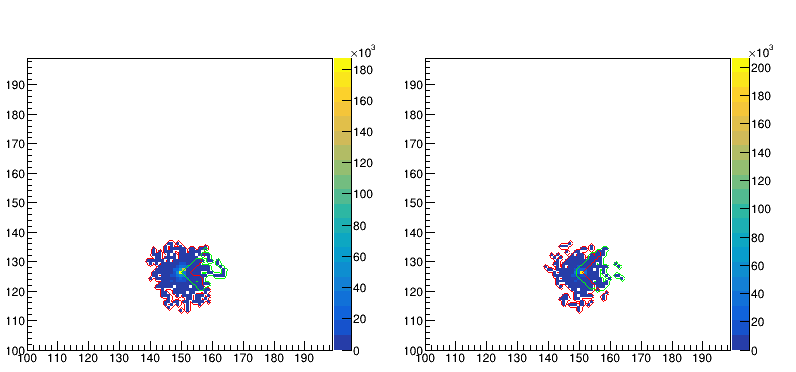

In [15]:
import ROOT
from array import array
C = output['cluster'].numpy()

h = ROOT.TH2F("","", 100, 100., 199., 100, 100., 199.)
c = ROOT.TCanvas("c1","c1", 800, 400)
c.Divide(2)
ROOT.gStyle.SetOptStat(0)
palette = [ROOT.kRed, ROOT.kGreen]
for l in range(2):
    c.cd(l+1)
    ROOT.gPad.SetLeftMargin(0.05)
    ROOT.gPad.SetBottomMargin(0.05)
    ROOT.gPad.SetRightMargin(0.15)
    ROOT.gPad.SetTopMargin(0.15)
    Cl = C[C[...,3]==l]
    idx = np.array([1,2,4])
    hk = []
    u = np.unique(Cl[:,0], axis=0).astype(int)
    htot = h.Clone()
    arr = array('d',[0.5])
    for k in range(len(u)):
        for i,j,x in Cl[Cl[...,0]==u[k]][:,idx]:
            hk.append(h.Clone())
            hk[k].Fill(j,i,x)
            htot.Add(hk[k])
    htot.DrawCopy("COLZ")

    for k in range(len(u)):
        hk[k].SetLineColor(palette[k])
        hk[k].SetLineWidth(1)
        hk[k].SetContour(1, arr)
        hk[k].DrawCopy("cont3 list same")

c.Draw()

In [ ]:
# initial values
TENERGY = 500
TLOCMAX = 350
TNUMBER = 3
# good values to test if recursive function works
TSEED = tf.constant(100, tf.float32)  # tf.constant([300.], tf.float32)
TNEIGHBOR = tf.constant(50., tf.float32)
TCELL = tf.constant(10., tf.float32)

In [ ]:
# EM 633
TENERGY = 5000
TLOCMAX = 500
TNUMBER = 3
# good values to test if recursive function works
TSEED = tf.constant(6., tf.float32)  # tf.constant([300.], tf.float32)
TNEIGHBOR = tf.constant(3., tf.float32)
TCELL = tf.constant(3., tf.float32)

In [ ]:
# # Had 420
# TENERGY = 0
# TLOCMAX = 500
# TNUMBER = 3
# # good values to test if recursive function works
# TSEED = tf.constant(4., tf.float32)  # tf.constant([300.], tf.float32)
# TNEIGHBOR = tf.constant(2., tf.float32)
# TCELL = tf.constant(0., tf.float32)

In [ ]:
cols = ['eventId', 'cluster_comi', 'cluster_comj', 'S_sum', 'S_rad_mean', 'S_hot', 'C_sum', 'C_rad_mean', 'C_hot']
pdf = pd.DataFrame(columns=cols)
i = 0
for parsed in dataset.take(10):
    print(i)
    output = cluster_maker(parsed)
    output2 = cluster_splitter(output)
    output3 = scalar_features(output2)
    s = parsed['scalar'].numpy()
    eventId = parsed['eventId'].numpy()
    eventId_rep = np.tile(eventId, [s.shape[0], 1])
    arr = np.hstack((eventId_rep, s))
    pdfi = pd.DataFrame(arr, columns=cols)
    pdf = pdf.append(pdfi)
    i += 1
pdf.reset_index(drop=True, inplace=True)
pdf.eventId = pdf.eventId.astype(int)
pdf.to_csv('clustering.csv', index=False)

In [ ]:
pdf

In [ ]:
pdf = pd.DataFrame(columns=['comi', 'comj', 'S_sum', 'S_rad_mean', 'S_hot', 'C_sum', 'S_rad_mean', 'C_hot'])
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 30))
i = 0
for parsed_record in dataset.take(1):
    plt.imshow(parsed_record['image'][:,:,0])
    plt.colorbar()
#     print(parsed_record['labels'])
#     output = cluster_maker(parsed_record)
#     A = output['proto'].numpy()
#     A1 = A[A[...,3] == 0][...,:3]
#     A2 = A[A[...,3] == 1][...,:3]
#     # A1 = np.unique(A1, axis=0)
#     # A2 = np.unique(A2, axis=0)
#     # print(A1)
#     sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[HEIGHT,WIDTH])
#     A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
#     sp = tf.SparseTensor(A2[...,1:3], A2[...,0], dense_shape=[HEIGHT,WIDTH])
#     A2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
#     ax[i][0].imshow(A1_dense)
#     ax[i][1].imshow(A2_dense)
    
#     output2 = cluster_splitter(output)
# #     A = output['cluster'].numpy()
# #     A1 = A[A[...,3] == 0][...,:3]
# #     A2 = A[A[...,3] == 1][...,:3]
# # #     # A1 = np.unique(A1, axis=0)
# # #     # A2 = np.unique(A2, axis=0)

#     output3 = scalar_features(output2)
#     print(parsed_record['scalar'])
# #     u = np.unique(A1[:,0])
# #     print(u)
    
# #     sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[HEIGHT,WIDTH])
# #     A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
# #     ax[i][1].imshow(A1_dense)
    
#     i += 1
#     print("eventId", parsed_record['eventId'])